In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from math import atan2, degrees, isnan, sqrt

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Implementation of Fixation Detection Algorithm based on Velocity

In [2]:
#Utility Functions
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
class EyeTracker(object):
    # Constructor
    def __init__(self, sampling_rate, distance, height, res_height, sac_min_thres, sac_max_thres, fix_max_thres, Vel_filter=None):
        self.sampling_rate = sampling_rate   # sampling rate = 1/T in Hz

        # Setup
        self.distance   = distance             # mm
        self.height     = height               # mm
        self.res_height = res_height           # mm

        # Calculating fixation and saccades threshold in pixel
        self.sac_min_thres = self.angle2pix(sac_min_thres)
        self.sac_max_thres = self.angle2pix(sac_max_thres)
        self.fix_max_thres = self.angle2pix(fix_max_thres)

        # Velocity FIR filter (two-tap filter as default)
        self.Vel_filter = Vel_filter
        if self.Vel_filter is None: self.Vel_filter = [1, -1]
        self.Vel_filter = [i*self.sampling_rate for i in self.Vel_filter]

        print("sac min: ", self.sac_min_thres, "\nSac max: ", self.sac_max_thres, "\nFix max: ", self.fix_max_thres)


    # Method for converting visual angle to pixel
    def angle2pix(self, value): 
      return value / (degrees(atan2(.5*self.height, self.distance)) / (.5*self.res_height))
    
    def pix2angle(self, value):
      return value * (degrees(atan2(.5*self.height, self.distance)) / (.5*self.res_height))


    # Fixation detection Method
    def detect_fixation(self, x, y, filter_data=False):
        self.x = x
        self.y = y

        N = len(x)                # size of data
        K = len(self.Vel_filter)  # size of velocity FIR filter

        # Calculating velocity x and y
        velocity_x = [0 for i in range (N-K-1)]
        velocity_y = [0 for i in range (N-K-1)]

        for i in range (N-K-1):
          for j in range (K):
              velocity_x[i] = velocity_x[i] + (x[i+j]*self.Vel_filter[j])
              velocity_y[i] = velocity_y[i] + (y[i+j]*self.Vel_filter[j])

        velocity = [((velocity_x[i] ** 2 + velocity_y[i] ** 2)**0.5) for i in range (N-K-1)]

        # Passing data through a low-pass filter to eliminate noise
        if filter_data:
          velocity = butter_lowpass_filter(velocity, cutoff=1.2, fs=30, order=5)

        # detection of fixation and saccades
        self.fixations_index = []
        self.saccades_index = []
        fixation_group = []
        saccades_group = []

        for i in range (N-K-1):
          # Saccade detected
          if(velocity[i] >= self.sac_min_thres and velocity[i] <= self.sac_max_thres):
            if(fixation_group):
              self.fixations_index.append(fixation_group)
              fixation_group = []
            saccades_group.append(i)

          # Fixation detected
          elif(velocity[i] <= self.fix_max_thres):       
            if(saccades_group):
              self.saccades_index.append(saccades_group)
              saccades_group = []
            fixation_group.append(i)

        if(fixation_group):
         self.fixations_index.append(fixation_group)
        if(saccades_group):
          self.saccades_index.append(saccades_group)
      
        return (self.fixations_index, self.saccades_index, velocity)
      
    # Get centroids x and y of each fixation groups
    def get_centroids(self):
      centroid_x = []
      centroid_y = []

      for group in self.fixations_index:
        centroid_x.append(sum([self.x[i] for i in group])/len(group))
        centroid_y.append(sum([self.y[i] for i in group])/len(group))
      return (centroid_x, centroid_y)

    # Get average duration and durations of each fixation groups in ms
    def get_durations(self):
      duration = []
      for fixation in self.fixations_index:
        duration.append((len(fixation)/self.sampling_rate) * 1000) # duration in ms
      return (numpy.mean(duration), duration)

    def get_saccades_amplitude(self):
      saccades   = [index for sublist in self.saccades_index for index in sublist]
      amplitudes = []
      for i in saccades:
        amplitudes.append(self.pix2angle((self.x[i] ** 2 + self.y[i] ** 2)**0.5))
      return amplitudes


# Reading Data


In [4]:
class GazeData(object):
    # Constructor
    def __init__(self, path):
        self.df = pd.read_csv(path, error_bad_lines=False)
    
    def get_no_sessions(self, subject_id):
      data = self.df[self.df.iloc[:, 0] == subject_id].to_numpy()
      return int(data.shape[0])
    
    def get_data(self, subject_id, session_index):
      data = self.df[self.df.iloc[:, 0] == subject_id].to_numpy()
      known = data[session_index, 1]
      sid   = numpy.delete(data[session_index, :], [0, 1])
      x = numpy.array(sid[::2], dtype=float)
      y = numpy.array(sid[1::2], dtype=float)
      return (known, x[~numpy.isnan(x)], y[~numpy.isnan(y)])



# Plotting Functions

In [45]:
# Functions for plotting gaze data
def plot_velocity(velocity):
  vel = butter_lowpass_filter(velocity, cutoff=1.2, fs=30, order=5)
  plt.plot(vel, "r", label='Velocity')
  plt.xlim(0, 2000)
  plt.hlines(ET.angle2pix(sac_min_thres), 0, 2000, colors='k', linestyles='dotted', label='Saccade min')
  plt.hlines(ET.angle2pix(fix_max_thres), 0, 2000, colors='k', linestyles='dashed', label='Fixation max')
  plt.legend(fontsize='xx-small', loc='upper right')
  plt.ylabel('Velocity (°/sec)')
  plt.show()

def plot_gaze_data(x, y, subject_id, fixations=None, saccades=None, centroid_x=None, centroid_y=None):
  plt.rcParams['figure.dpi'] = 200
  plt.scatter(x, y, s=0.5, color='blue')
  if fixations is not None:
    fix_x = x[fixations]
    fix_y = y[fixations]
    plt.scatter(fix_x, fix_y, s=0.5, color='red', label="Fixation")
    sac_x = x[saccades]
    sac_y = y[saccades]
    plt.scatter(sac_x, sac_y, s=0.5, color='blue', label="Saccades")
    plt.scatter(centroid_x, centroid_y, s=50, alpha=0.6, color='orange', label="Centroids")
    plt.legend(borderpad=1)
    plt.title("Gaze Data with Fixations")
  else: 
    plt.title('Gaze Data: '+ subject_id)

  plt.xticks(range(-700, 800, 100))
  plt.yticks(range(-700, 800, 100))
  plt.tick_params(axis='both', which='major', labelsize=5)
  plt.xlabel('x-axis')
  plt.ylabel('y-axis')
  plt.show()

def plot_relative_position(x, y):
  plt.plot(x[0:5000], "r", label='x-position')
  plt.plot(y[0:5000], "b", label='y-position')
  plt.ylabel('Relative Position')
  plt.legend(fontsize='xx-small', loc='upper right')
  plt.show()

def plot_saccades_prob(x, saccades):
  is_saccades = [ True if (i in saccades) else False for i in range(len(x))]
  plt.ylim(0, 1.5)
  plt.step(is_saccades[0:5000], 'r', linewidth = 0.5, where='post', label="Saccade Probability")
  plt.legend(fontsize='xx-small', loc='upper right')
  plt.show()

def plot_saccade_amplitude(x, saccades, saccades_amplitude):
  amplitude = [saccades_amplitude[saccades.index(i)] if (i in saccades) else 0 for i in range(len(x))]
  plt.plot(amplitude, 'r', linewidth = 0.5, label="Saccades Amplitude")
  plt.legend(fontsize='xx-small', loc='upper right')
  plt.xlabel('Data Points')
  plt.ylabel('Amplitude (°)')
  plt.show()

def plot_centroid_duration(centroid_x, centroid_y, duration, mean_duration):
  plt.plot(centroid_x, centroid_y, linewidth = 0.5, label="Saccades")
  plt.scatter(centroid_x, centroid_y, s=duration, alpha=0.6, color='orange', label="Centroids (size is duration in ms)")

  plt.legend(borderpad=1, fontsize='xx-small', markerscale=0.5)
  plt.xticks(range(-700, 800, 100))
  plt.yticks(range(-700, 800, 100))
  plt.title("Gaze Data with Fixations Mean Duration: "+str("{:.2f}".format(mean_duration))+"ms")
  plt.tick_params(axis='both', which='major', labelsize=5)
  plt.xlabel('x-axis')
  plt.ylabel('y-axis')
  plt.show()

def plot_MFD_Subject(sid, MFD, MFD_SD, text):
  plt.errorbar(sid, MFD, MFD_SD, linestyle='None', fmt='-o', label="mean & std", capsize=2, ecolor='red')
  plt.legend(fontsize='xx-small', loc=4)
  plt.xlabel('Subjects')
  plt.ylabel(text)
  plt.show()


def plot_MSA_MFD(sid, MFD, MSA, text):
  plt.scatter(MFD, MSA, s=2, color='r', label="MFD-MSA (" + text + ")")
  for i, txt in enumerate(sid):
      plt.annotate(txt, (MFD[i]+0.3, MSA[i]), size=5)

  plt.legend(fontsize='xx-small', loc=4)
  plt.title("MSA "+text+ " x MFD "+text)
  plt.tick_params(axis='both', which='major', labelsize=5)
  plt.xlabel('MFD ' + text+' (ms)')
  plt.ylabel('MSA ' + text+ ' (°)')
  plt.show()


# Main Code

### Parameters Settings

In [70]:
# Parameters Settings
sampling_rate = 1000      # 1/T = 1000Hz

# Setup
distance      = 450       # mm
height        = 113       # mm
res_height    = 1400

# Fixation and Saccade Threshold
sac_min_thres = 130       # degree
sac_max_thres = 750       # degree
fix_max_thres = 50        # degree

# Initialization of Gaze Data
GD = GazeData('/content/drive/MyDrive/Eye Tracking/train.csv')

#Initialization of EyeTracker
ET = EyeTracker(sampling_rate, distance, height, res_height, sac_min_thres, sac_max_thres, fix_max_thres)

b'Skipping line 81: expected 17488 fields, saw 26864\n'
b'Skipping line 152: expected 17488 fields, saw 33138\nSkipping line 160: expected 17488 fields, saw 20410\n'
b'Skipping line 472: expected 17488 fields, saw 23290\n'
b'Skipping line 548: expected 17488 fields, saw 28096\n'
b'Skipping line 571: expected 17488 fields, saw 44026\n'
b'Skipping line 600: expected 17488 fields, saw 22990\n'
b'Skipping line 622: expected 17488 fields, saw 17680\n'
b'Skipping line 651: expected 17488 fields, saw 31846\n'
b'Skipping line 688: expected 17488 fields, saw 21864\n'
b'Skipping line 728: expected 17488 fields, saw 21032\n'
b'Skipping line 760: expected 17488 fields, saw 20060\n'
b'Skipping line 842: expected 17488 fields, saw 18164\n'


sac min:  12715.969770236614 
Sac max:  73361.36405905739 
Fix max:  4890.757603937159


### For Subject 5, Session 4

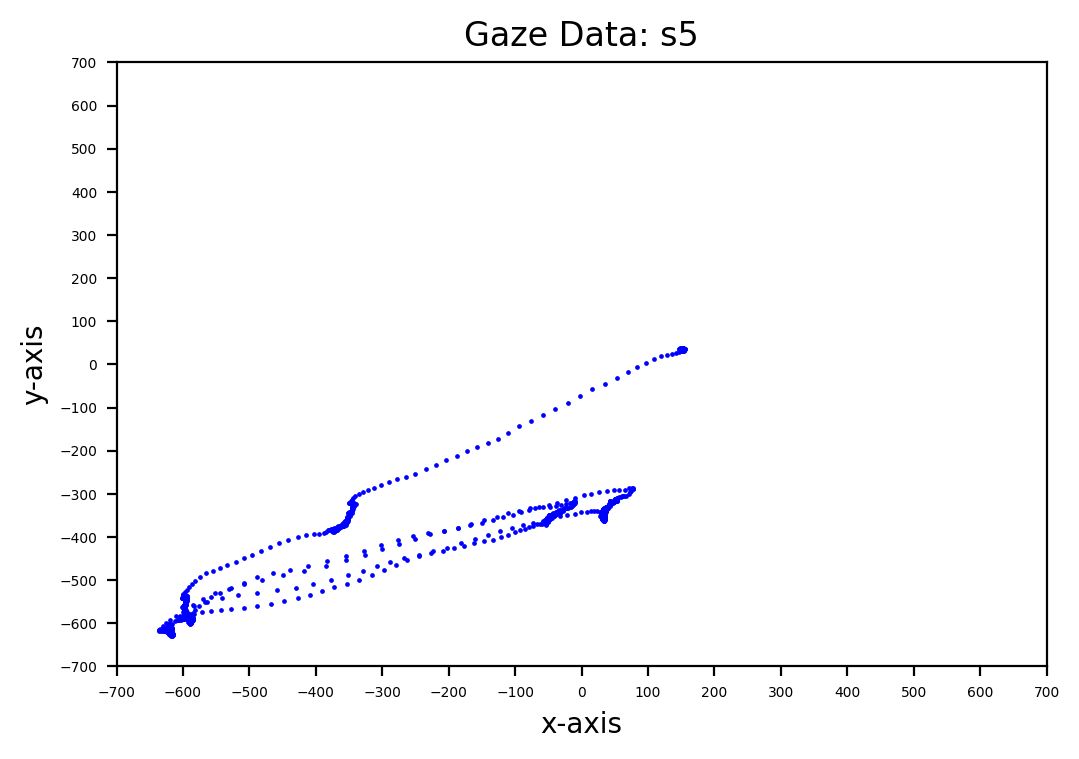

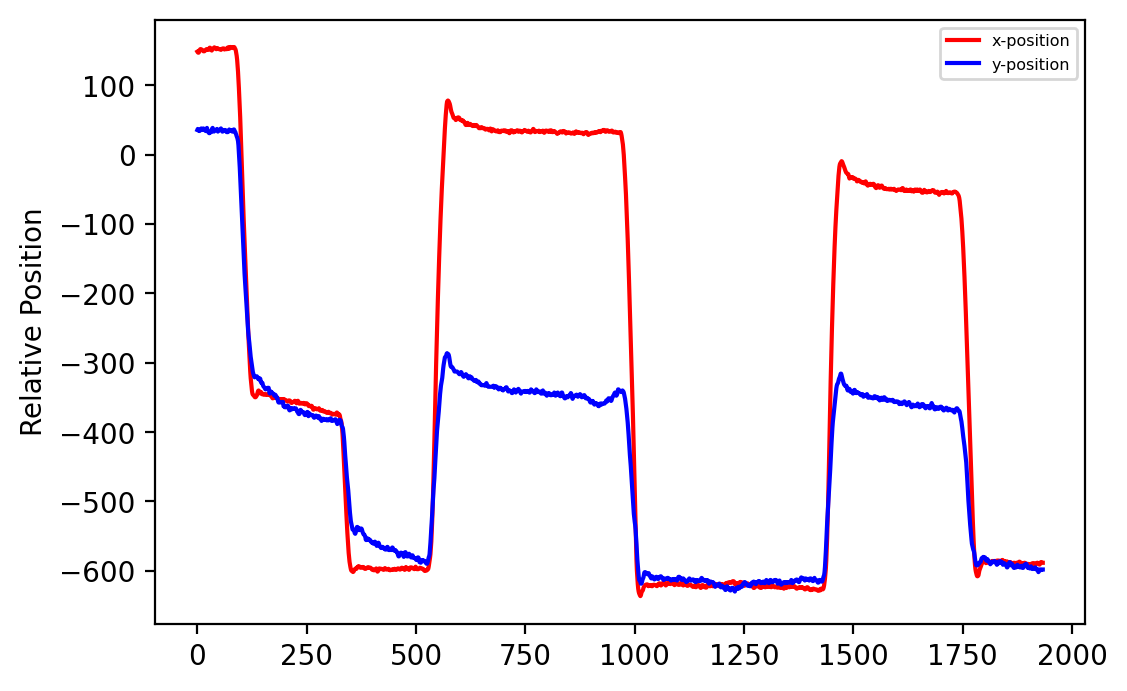

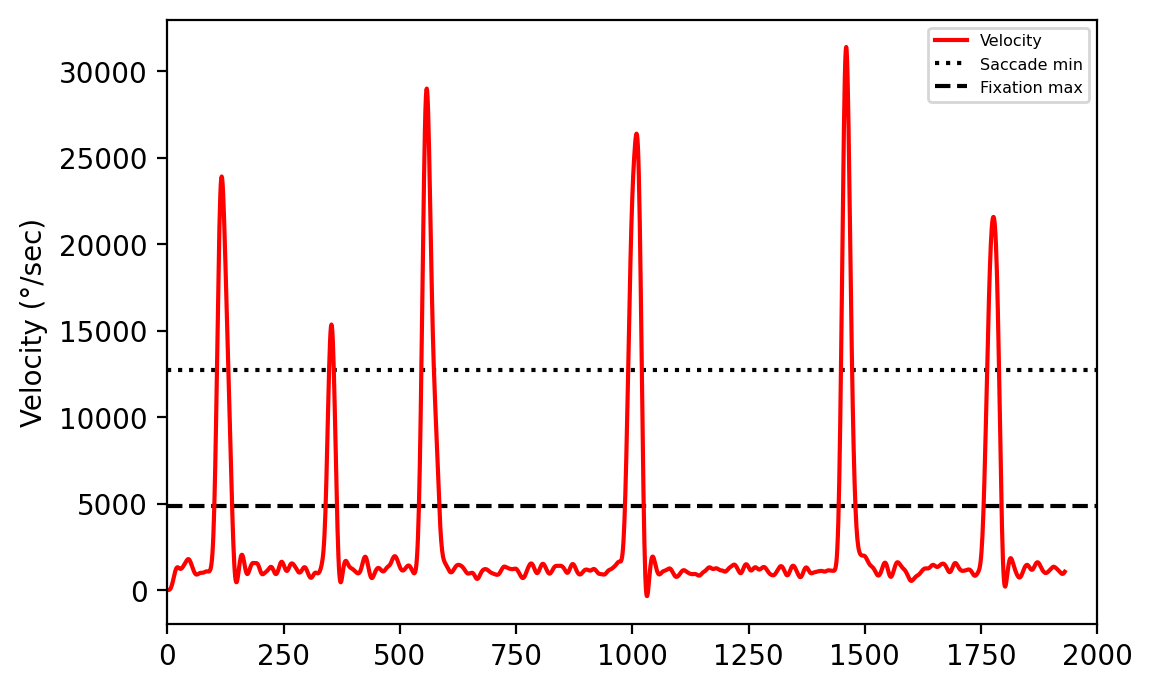

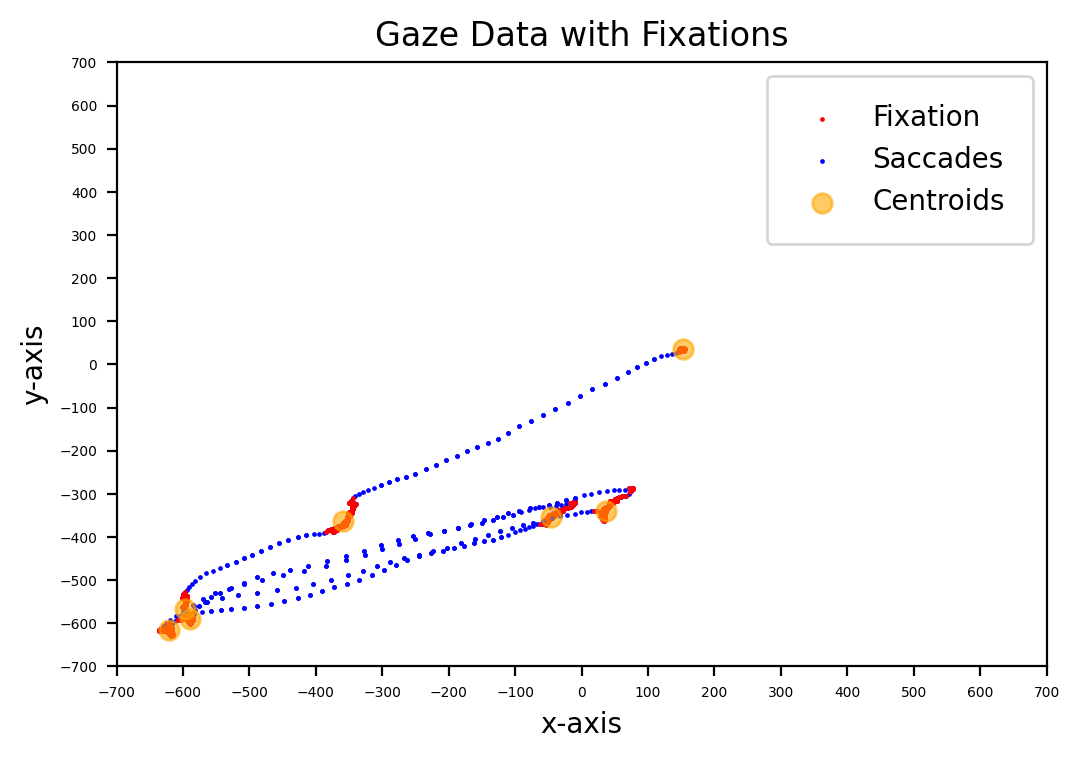

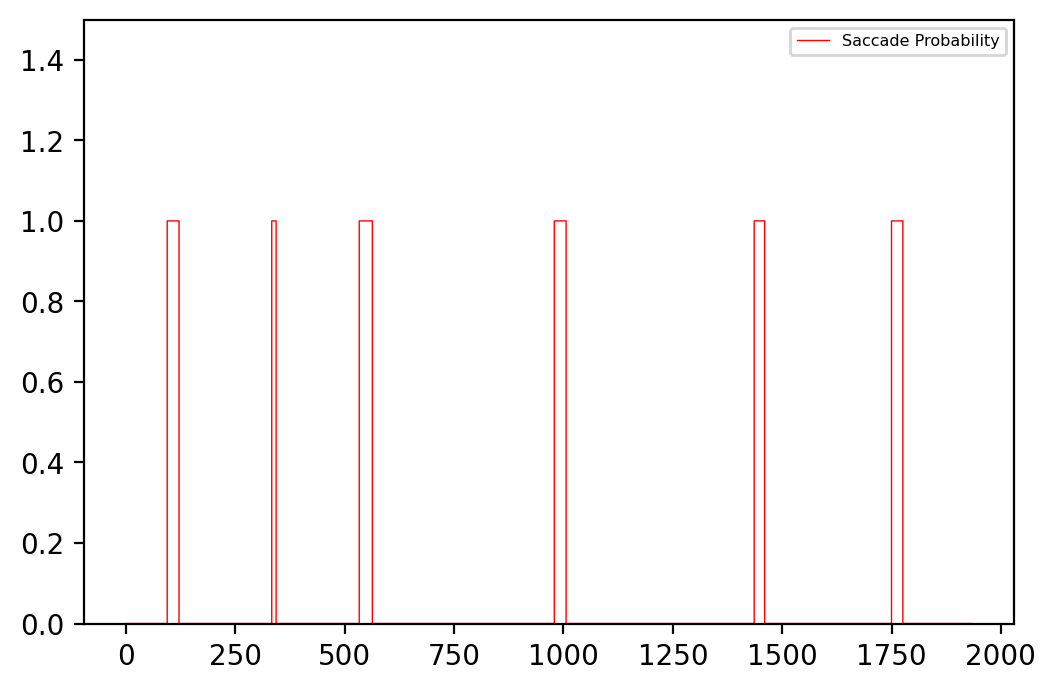

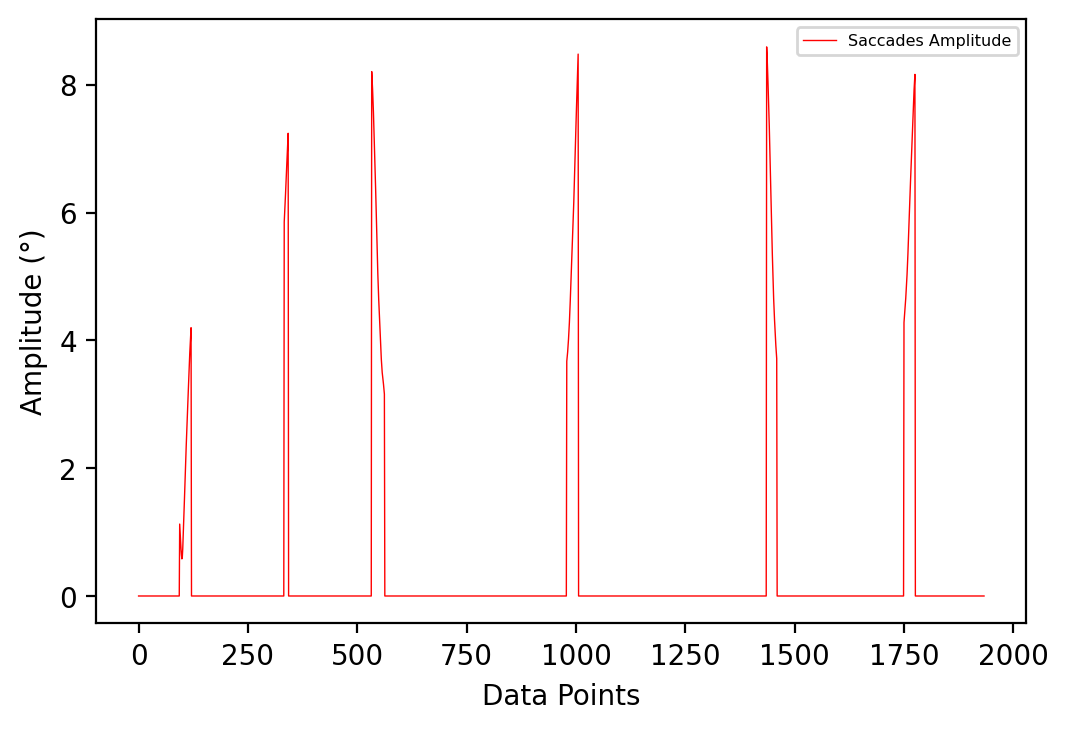

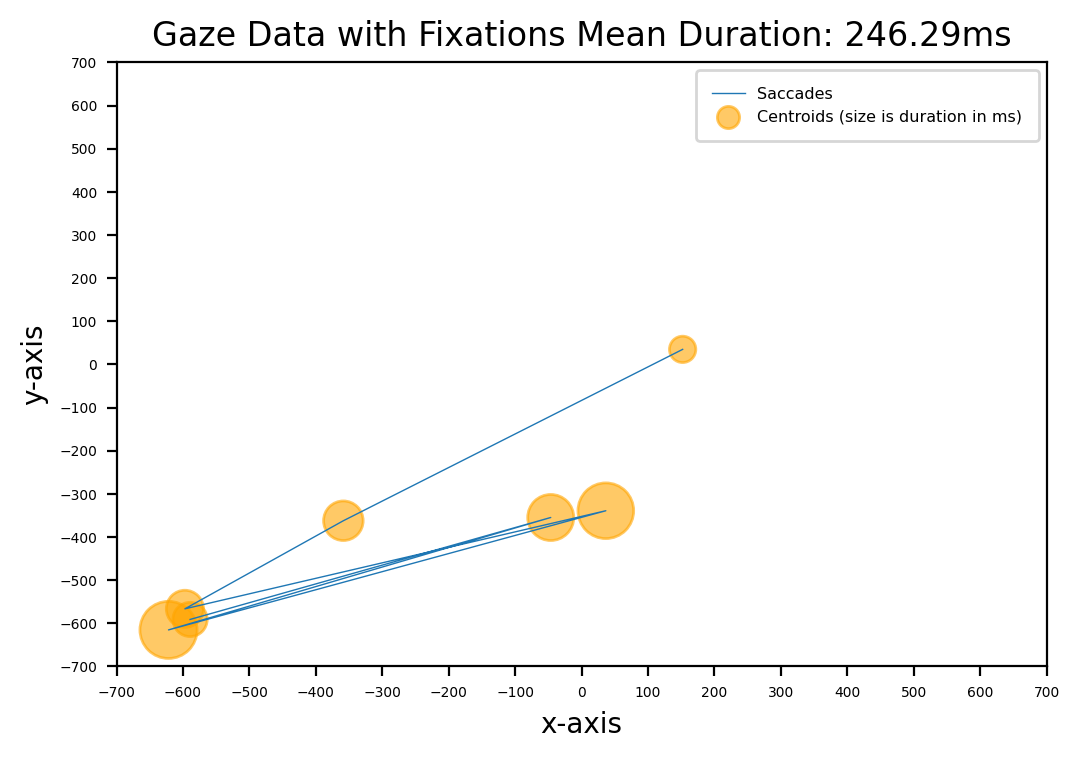

Average Fixation Durations 246.28571428571428
Number of Fixations:  7
Fixation Durations:  [90.0, 203.0, 179.0, 402.0, 423.0, 275.0, 152.0]
Centroids x-axis:  [152.16522222222224, -358.5721182266011, -597.11217877095, 36.526815920398, -621.7815366430269, -46.38592727272728, -589.3042105263156]
Centroids y-axis:  [34.93200000000001, -362.24995073891665, -566.4578770949719, -339.10597014925395, -615.3042316784883, -354.7477818181816, -591.0775657894733]


In [71]:
[known, x, y] = GD.get_data('s5', 3)

# Plotting gaze data and relative position
plot_gaze_data(x, y, 's5')
plot_relative_position(x, y)

# detecting fixations
[fixation_index, saccades_index, velocity] = ET.detect_fixation(x, y, False)    
plot_velocity(velocity) # plotting velocity against gaze sample
fixation = [index for sublist in fixation_index for index in sublist]
saccades = [index for sublist in saccades_index for index in sublist]

# Calculating centroids
[centroid_x, centroid_y] = ET.get_centroids()                                   

# Plot gaze data with detected fixations in red, saccades in blue and centroids
plot_gaze_data(x, y, 's1', fixation, saccades, centroid_x, centroid_y)

# Plotting saccades probability
plot_saccades_prob(x, saccades)


# Calculating saccades amplitude
saccades_amplitude = ET.get_saccades_amplitude()
plot_saccade_amplitude(x, saccades, saccades_amplitude)

# Calculating Durations in ms
[mean_duration, duration] = ET.get_durations()                                  

# Plotting Centroid and Duration
plot_centroid_duration(centroid_x, centroid_y, duration, mean_duration)

print('Average Fixation Durations', mean_duration)
print('Number of Fixations: ',  len(fixation_index))

print('Fixation Durations: ', duration)
print('Centroids x-axis: ', centroid_x)
print('Centroids y-axis: ', centroid_y)

### For all given subjects

In [72]:
subjects_id = ['s1','s5','s7','s18','s19','s21','s27','s33']

fix_dur_overall = []
fix_dur_true    = []
fix_dur_false   = []

sac_amp_overall = []
sac_amp_true    = []
sac_amp_false   = []

# Mean and Standard deviation of durations
MFD_true        = []
MFD_false       = []
MFD_SD_true     = []
MFD_SD_false    = []

MFD_overall     = []
MFD_SD_overall  = []

# Mean and Standard deviation of saccades' amplitudes
MSA_true        = []
MSA_false       = []
MSA_SD_true     = []
MSA_SD_false    = []

MSA_overall     = []
MSA_SD_overall  = []

for sid in subjects_id:
  no_sessions = GD.get_no_sessions(sid)
  for i in range (no_sessions):
    [known, x, y] = GD.get_data(sid, i)                                          # get data
    [fixation_index, saccades_index, velocity] = ET.detect_fixation(x, y, False) # detect fixation
    [mean_duration, duration] = ET.get_durations()                               # calculate durations
    saccades_amplitude = ET.get_saccades_amplitude()                             # calculate saccades amplitudes

    # if image is known
    if known: 
      fix_dur_true.extend(duration)
      sac_amp_true.extend(saccades_amplitude)
    else :
      fix_dur_false.extend(duration)
      sac_amp_false.extend(saccades_amplitude)

  # calculation of mean and standard deviation of durations 
  MFD_true.append(numpy.mean(fix_dur_true))
  MFD_false.append(numpy.mean(fix_dur_false))
  MFD_SD_true.append(numpy.std(fix_dur_true))
  MFD_SD_false.append(numpy.std(fix_dur_false))

  MFD_overall.append(numpy.mean(fix_dur_true + fix_dur_false))
  MFD_SD_overall.append(numpy.std(fix_dur_true + fix_dur_false))

  # calculation of mean and standard deviation of saccades' amplitudes
  MSA_true.append(numpy.mean(sac_amp_true))
  MSA_false.append(numpy.mean(sac_amp_false))
  MSA_SD_true.append(numpy.std(sac_amp_true))
  MSA_SD_false.append(numpy.std(sac_amp_false))

  MSA_overall.append(numpy.mean(sac_amp_true + sac_amp_false))
  MSA_SD_overall.append(numpy.std(sac_amp_true + sac_amp_false))


# For all Subjects
aggregated_MFD    = numpy.mean(MFD_overall)
aggregated_MFD_SD = numpy.std(MFD_overall)
aggregated_MSA    = numpy.mean(MSA_overall)
aggregated_MSA_SD = numpy.std(MSA_overall)
print("Aggregated Mean Fixation Duration (MFD) for all subjects is : ", aggregated_MFD, "ms and its standard deviation is: ", aggregated_MFD_SD)
print("Aggregated Mean Saccade Amplitude (MSA) for all subjects is : ", aggregated_MSA, "° and its standard deviation is: ", aggregated_MSA_SD)



Aggregated Mean Fixation Duration (MFD) for all subjects is :  225.4907073569226 ms and its standard deviation is:  25.907918663824777
Aggregated Mean Saccade Amplitude (MSA) for all subjects is :  5.2152766583373875 ° and its standard deviation is:  0.6936041351019592


#### Writing to csv file



In [75]:
new_dataframe = pd.DataFrame({"subject_id" : subjects_id,  
                              "MFD_true" : MFD_true, "MFD_false" : MFD_false, "MFD_SD_true" : MFD_SD_true, "MFD_SD_false" : MFD_SD_false,  
                              "MFD_overall" : MFD_overall, "MFD_SD_overall" : MFD_SD_overall, 
                              "MSA_true" : MSA_true, "MSA_false" : MSA_false, "MSA_SD_true" : MSA_SD_true, "MSA_SD_false" : MSA_SD_false,  
                              "MSA_overall" : MSA_overall, "MSA_SD_overall" : MSA_SD_overall,
                              })

new_dataframe.to_csv("/content/drive/MyDrive/Eye Tracking/result.csv", index=False)

#### MFD and MSA Plots

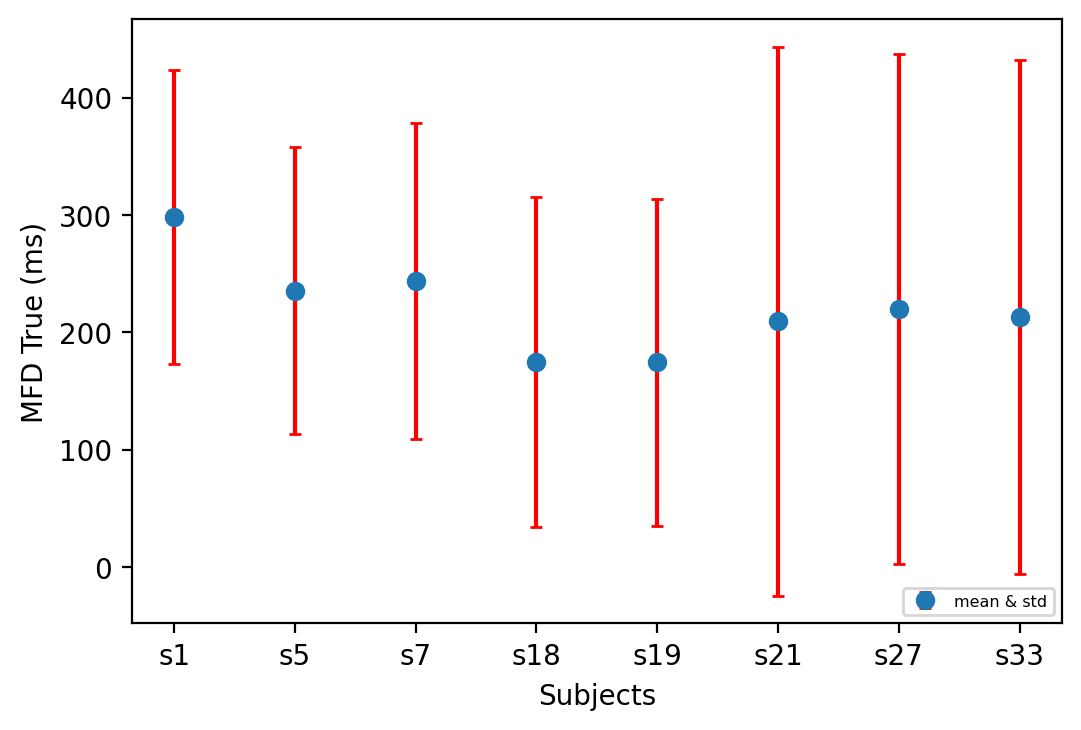

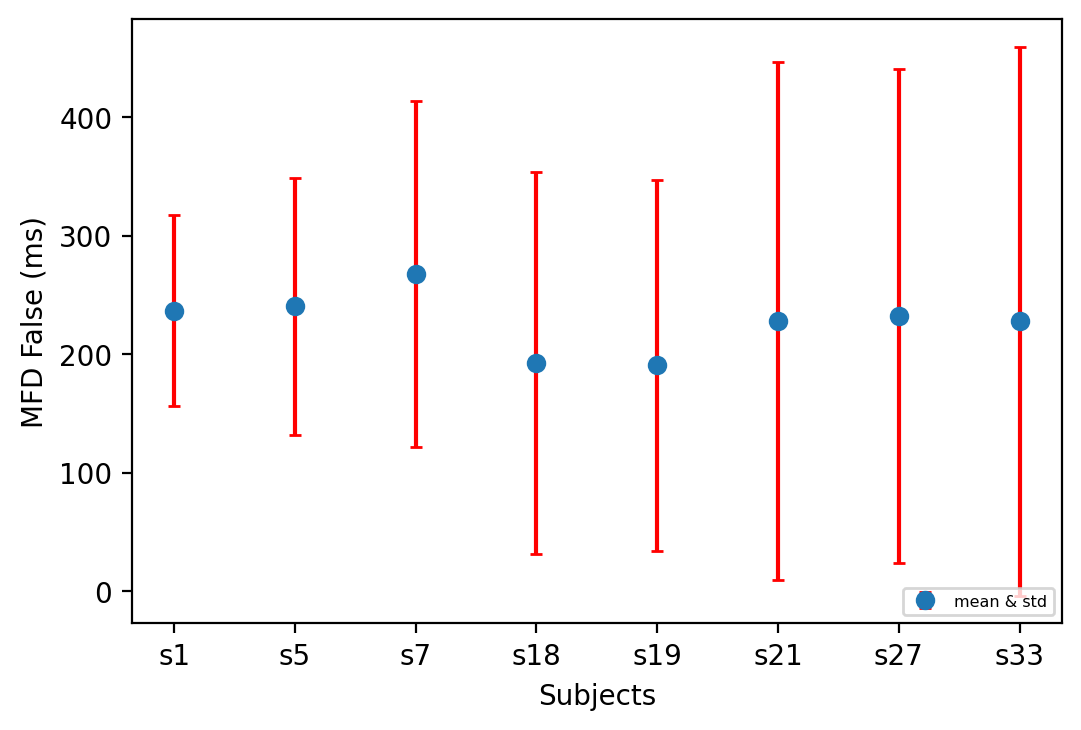

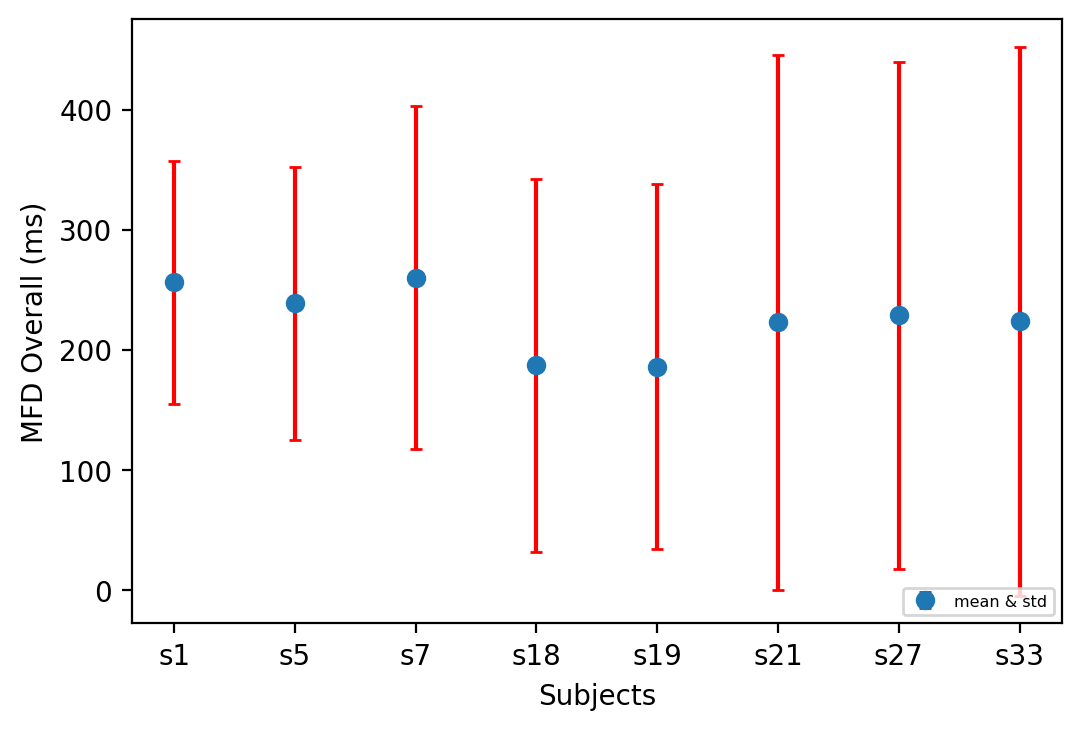

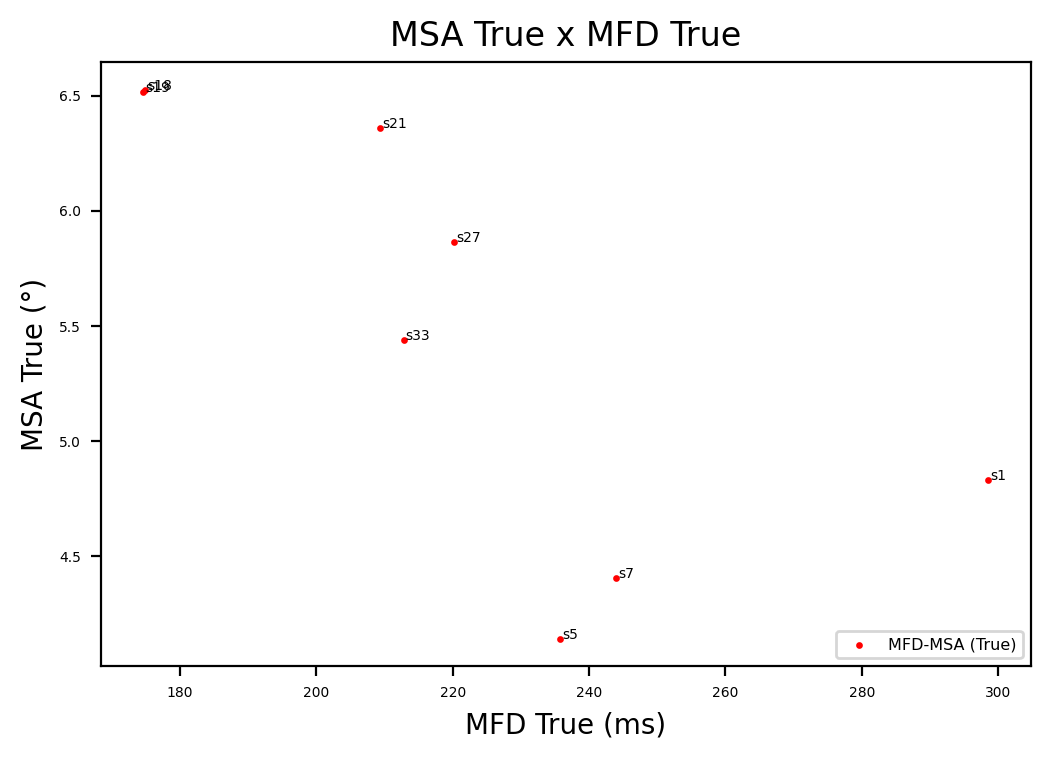

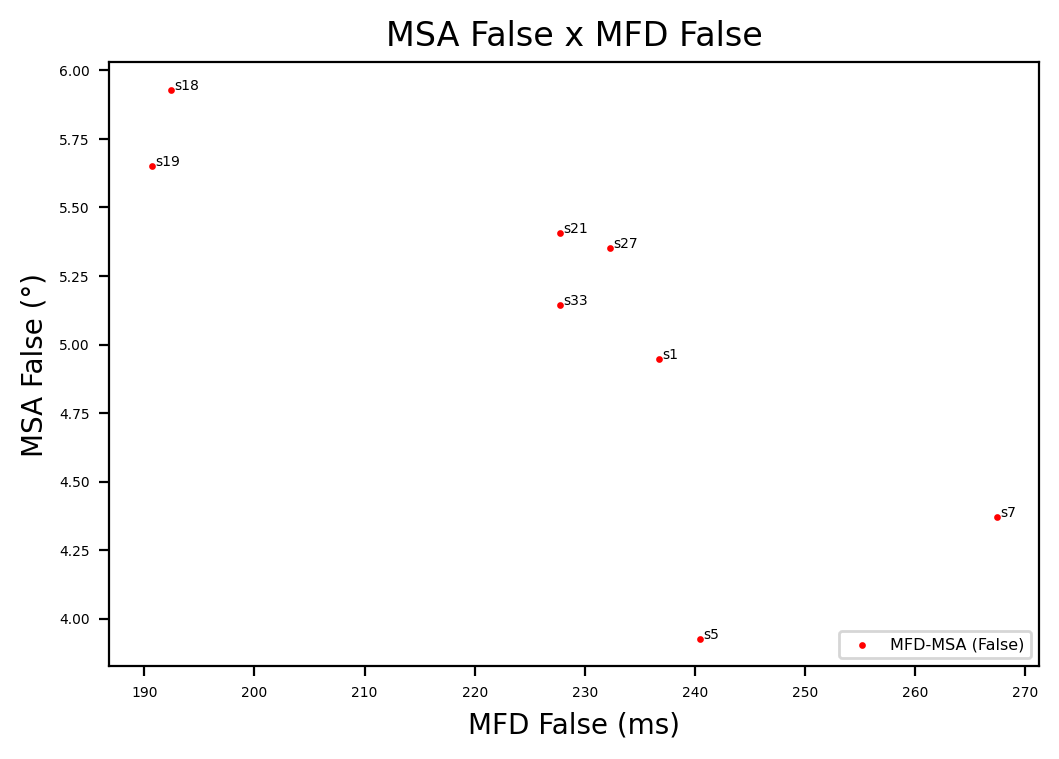

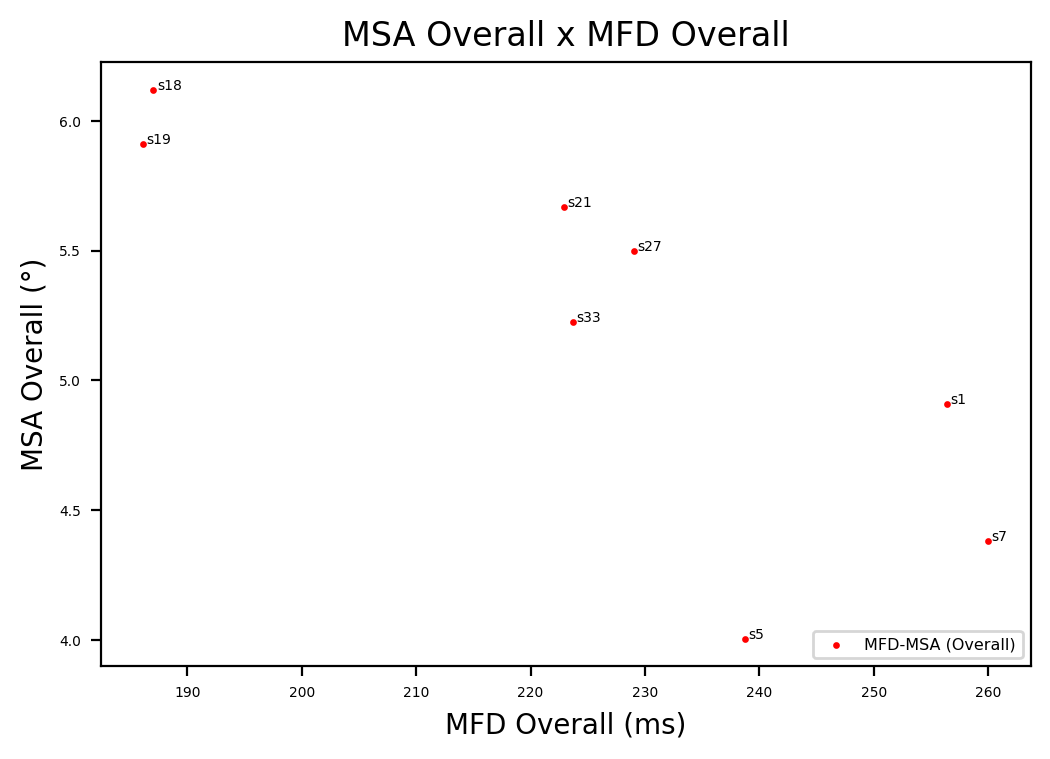

In [76]:
# Plots - Mean and std of known=true and known=false (for aggregated data of all your subjects)
plot_MFD_Subject(subjects_id, MFD_true, MFD_SD_true, 'MFD True (ms)')
plot_MFD_Subject(subjects_id, MFD_false, MFD_SD_false, 'MFD False (ms)')
plot_MFD_Subject(subjects_id, MFD_overall, MFD_SD_overall, 'MFD Overall (ms)')

# Plots - MSA x MFD 
plot_MSA_MFD(subjects_id, MFD_true, MSA_true, "True")
plot_MSA_MFD(subjects_id, MFD_false, MSA_false, "False")
plot_MSA_MFD(subjects_id, MFD_overall, MSA_overall, "Overall")